# Sound localisation with surrogate gradient descent

This is a concise version of the SNN implementation of the sound localization task. Detailed explanations from the tutorial are removed to make it an accessible code to develop you project.

## To setup before you start
First, download a copy of this notebook to your personal google drive:
1. mount your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Save a copy of the notebook to your drive: "Files" => "Save a copy in Drive"
3. Locate where this copy was saved in your dirve: "Files" => "Locate in Drive"
4. Now you can rename the located file and move it to a location of your choice in your google drive


## Data Generation

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

my_computer_is_slow = True # set this to True if using Colab

import pdb
import pandas as pd

### Input signal parameter configuration

Here's a picture of the architecture for the stimuli:


<img src="https://github.com/neural-reckoning/cosyne-tutorial-2022/blob/main/arch-stimuli.png?raw=1" alt="Stimuli architecture" width="400" height="240">

In [ ]:
# We use the following constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

# Stimulus and simulation parameters
dt = 1*ms            # large time step to make simulations run faster for tutorial
anf_per_ear = 100    # number of auditory nerve fibers connected to each ear with independent noise
envelope_power = 2   # higher values make sharper envelopes. Easier by eye => But does the network perform better ?
rate_max = 600*Hz    # maximum Poisson firing rate
f = 20*Hz            # stimulus frequency
duration = .1*second # stimulus duration
duration_steps = int(np.round(duration/dt))  # number of simulation steps
input_size = 2*anf_per_ear

### Input signal generation function


The functions below return two arrays ``ipd`` and ``spikes``.

- ``ipd`` is an array of length ``num_samples`` that gives the true IPD,
- ``spikes`` is an array of 0 (no spike) and 1 (spike) of shape ``(num_samples, duration_steps, 2*anf_per_ear)``, where - ``duration_steps`` is the number of time steps there are in the stimulus.

In [ ]:
# Generate an input signal (spike array) from array of true IPDs
def input_signal(ipd, envelope_power=envelope_power):
    """
  Generate a Poisson spike train based on an input Interaural Phase Difference (IPD) array
  and the delays imposed by the individual auditory nerve fibers.

    Parameters
    ----------
    ipd : array-like
        An array of true Interaural Phase Differences (IPD). Shape: (num_samples, )
    envelope_power : float, optional
        A parameter controlling the strength of the signal envelope, which modulates
        the spike train generation. Default value is the globally defined `envelope_power`.

    Returns
    -------
    spikes : ndarray
        A binary array indicating spike occurrences, shaped (num_samples, duration_steps, 2*anf_per_ear).
        `spikes[i, j, k]` is 1 if a spike occurred at the jth time step for the ith IPD in the kth auditory nerve fiber,
        and 0 otherwise.

    Notes
    -----
    - The function first calculates an array of phases (`phi`) to define the sinudoidal auditory stimulus and adds a random
    phase offset because we want that the system learns to infer the angular location of the sound source indepent of its distance
    to the source.
    - An array of theta values is initialized that will hold the transformed phi values according to the phase delay  imposed by the
    individual auditory nerve fibers and the ipd between the two ears.
    - Different phase delays, ranging from 0 to pi/2, are calculated and added with the ipd value to generate theta.
    - Poisson spikes are generated based on the theta values and a sinusoidal modulation of the firing rate.
    - The spikes are returned as a binary array, indicating the occurrence of spikes across auditory nerve fibers and time.
  """
    num_samples = len(ipd) # corresponds to the number of different locations of the source in the data set

    T = np.arange(duration_steps)*dt # array of times over which the auditory signal is constructed
    phi = 2*np.pi*(f*T) + 2*np.pi*np.random.rand() # array of phases corresponding to those times with random offset
    # because we want that the system learns to infer the angular location of the sound source indepent of its distance
    # to the source. The phase in this array increases linearly.

    phase_delays = np.linspace(0, np.pi/2, anf_per_ear) # array of phase delays introduced by the auditory nerve fibers.
    # For each ear, we have anf_per_ear different phase delays from 0 to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2

    theta = np.zeros((num_samples, duration_steps, 2*anf_per_ear)) # 3D array that holds the spike pattern of all auditory nerve fibers for all the interaural phase difference in the data set.
    # num_samples = number of different IPD values in our data set
    # duration_step = number of time points in our auditory signal
    # 2*anf_per_ear = total number of auditory nerve fibers

    # Now we set up these theta values. Some numpy vectorisation logic using broadcasting to implements the idea in the text above.
    theta[:, :, :anf_per_ear] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, anf_per_ear:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]

    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = rate_max*dt*(0.5*(1+np.sin(theta)))**envelope_power > np.random.rand(num_samples, duration_steps, 2*anf_per_ear)
    return spikes, theta

# Generate some true IPDs from (-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples, envelope_power=envelope_power, tensor=True):
    """
    Generate random Interaural Phase Differences (IPDs) and then corresponding spike arrays using
    the function input_signal(idp).

      The function generates `num_samples` IPDs, uniformly distributed in the range (-pi/2, pi/2).
      It then generates corresponding spike arrays using the `input_signal` function.
      Optionally, IPDs and spike arrays can be converted to PyTorch tensors.

      Parameters
      ----------
      num_samples : int
          The number of IPD samples to generate.
      envelope_power : float, optional
          A parameter controlling the strength of the signal envelope, which modulates
          the spike train generation. Default value is the globally defined `envelope_power`.

      tensor : bool, optional
          If True, converts the IPDs and spike arrays to PyTorch tensors before returning them.
          If False, they are returned as NumPy arrays. Default is True.

      Returns
      -------
      ipd : ndarray or Tensor
          An array of randomly generated IPDs. Shape: (num_samples, ).
          Returned as a PyTorch tensor if `tensor` is True, otherwise as a NumPy array.
      spikes : ndarray or Tensor
          A binary array indicating spike occurrences along time, generated by `input_signal` based on `ipd`.
          Returned as a PyTorch tensor if `tensor` is True, otherwise as a NumPy array.
          Shaped: (num_samples, duration_steps, 2*anf_per_ear)

      Notes
      -----
      - Ensure that the `input_signal` function is defined in your environment as it is called within this function.
      - If `tensor` is True, ensure that PyTorch is installed and configured in your environment.

      Examples
      --------
      >>> ipd, spikes = random_ipd_input_signal(50, tensor=False)
      >>> print(ipd.shape, spikes.shape)
      (50,) (50, duration_steps, 2*anf_per_ear)
  """
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes, theta = input_signal(ipd)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes, theta



#### Test the input data generation fuction

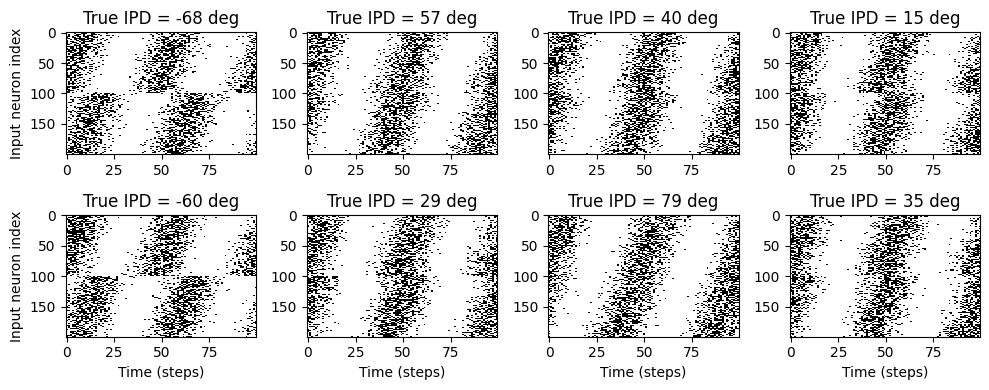

In [ ]:
# Plot for a few true IPDs the generated spike trains of the auditory nerve fibers to show how it looks.
# The first 100 lines are auditory nerve fiber responses of the righ ear and the others are from the left ear.
# You note that the IPDs was applied to the left ear's fibers.
ipd, spikes, _ = random_ipd_input_signal(8)
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
    if i>=4:
        plt.xlabel('Time (steps)')
    if i%4==0:
        plt.ylabel('Input neuron index')
plt.tight_layout()

### Classification helper functions

The objective is to take the input spike data and infer the **Interaural Phase Difference (IPD)** using a neural network. To achieve this, we will:

- **Discretize the IPD range** into categories (segments).  
- **Train a neural network** to predict the category (segment) to which the input belongs.

  This classification approach simplifies the continuous IPD estimation problem by transforming it into a discrete class prediction task, making it computationally efficient and suitable for neural network-based learning.




#### We define two helper functions:

Function 1: discretise(ipds)
  - This function discretises the IPD range into $N_c$ classes.

Function 2: continuise(ipd_indices)
  - This function maps IPD indices back to continuous IPD values.




In [ ]:
# classes at 15 degree increments
num_classes = 180//15
print(f'Number of classes = {num_classes}')

def discretise(ipds):
    """
      Discretize Interaural Phase Differences (IPDs) to generate class labels.

      The function maps IPDs, which are continuous values in the range (-pi/2, pi/2),
      to discrete classes in the range [0, num_classes-1]. The resulting discrete values
      are suitable for classification tasks.

        Parameters
        ----------
        ipds : Tensor
            A tensor containing continuous IPD values. The values should be in the range (-pi/2, pi/2).

        Returns
        -------
        Tensor
            A tensor containing the classification of IPD values, in the range [0, num_classes-1].

        Notes
        -----
        - Assumes the input `ipds` is a PyTorch tensor.
        - `num_classes` should be defined in the surrounding scope.
        - The output tensor will have the same shape as the input `ipds`.

        Examples
        --------
        >>> ipds = torch.tensor([-np.pi/2, 0, np.pi/2])
        >>> ipd_indices = discretise(ipds)
    """
    return ((ipds+np.pi/2)*num_classes/np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    """
      This function maps IPD indices, which are discrete values in the range [0, num_classes-1],
      back to continuous IPD values. The resulting continuous values are suitable for
      representing the midpoints of the original IPD ranges in the continuous domain.

        Parameters
        ----------
        ipd_indices : array-like
            An array or tensor of IPD indices, which are discrete values obtained from
            discretizing continuous IPDs into `num_classes` bins by the function discretise(ipds).

        Returns
        -------
        array-like
            An array or tensor of continuous IPD midpoints, corresponding to the provided
            `ipd_indices`. The midpoints are computed based on the assumed discretization
            strategy, and are in the range (-pi/2, pi/2).

        Notes
        -----
        - `num_classes` should be defined in the surrounding scope and should be the same
          value that was used for discretization.
        - The input `ipd_indices` and the output will have the same shape.
        - The output type (e.g., NumPy array, PyTorch tensor) will match the input type.
    """
    return (ipd_indices+0.5)/num_classes*np.pi-np.pi/2

Number of classes = 12


### Batch and sample size configuration

sample size = batch_size * n_training_batches

In [ ]:
# Parameters for training. These aren't optimal, but instead designed
# to give a reasonable result in a small amount of time for the tutorial!
if my_computer_is_slow:
    batch_size = 64
    n_training_batches = 64
else:
    batch_size = 128
    n_training_batches = 128
n_testing_batches = 32
num_samples = batch_size*n_training_batches

# NOTE 1:A batch is a subset of the training dataset used for a single update of the model parameters.
# Rather than updating model parameters after processing each individual data point (stochastic gradient descent),
# batches allow the network to update parameters after processing a group of data points.
# This approach is called mini-batch gradient descent and is more computationally efficient than stochastic gradient descent.
# The size of a batch, known as the batch size, is an important hyperparameter and can affect
# the model's training dynamics and performance.

# NOTE2 : Small batch sizes improve generalization through noisier gradients and
# require less memory, making them ideal for limited resources, but they may
# lead to slower computation and less stable convergence due to noisier gradient
# updates. Conversely, large batch sizes enhance computational efficiency and stability
# of gradient estimates due to better GPU utilization, but they demand more memory and
# might result in poorer generalization due to the risk of converging to sharp minima
# that don't generalize well on unseen data.

### Data generator function (iterating over the data in batches)

In [ ]:
# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    """
    Generate batches of data, iterating over IPDs and spikes in a randomized order.

    This generator function yields shuffled batches of interaural phase differences (IPDs) and spikes,
    facilitating mini-batch gradient descent training of a model. The order of the data is randomized
    to improve learning, mitigating the risk of the model memorizing the order of the training data
    (overfitting) and helping the model generalize better to unseen data.

      Parameters
      ----------
      ipds : Tensor
          A 1D tensor of IPD values.
          Shape: (n_samples, )
      spikes : Tensor
          A 3D tensor representing a batch of input spike trains.
          Shape: (n_samples, duration_steps, input_size)

      Yields
      ------
      spike_batch : Tensor
          A 3D tensor containing a batch of input spike trains.
          Shape: (batch_size, duration_steps, input_size)
      ipd_batch : Tensor
          A 1D tensor containing a batch of IPD values.
          Shape: (batch_size, )

      Notes
      -----
      - `batch_size` should be defined in the surrounding scope or passed as an argument.
      - Ensure that `ipds` and the first dimension of `spikes` have the same size.
      - The generator yields `spike_batch` and `ipd_batch` which are randomly shuffled batches of `spikes` and `ipds` respectively.
    """
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        spike_batch = spikes[i*batch_size:(i+1)*batch_size, :, :]  # spike_batch
        ipd_batch   = ipds[i*batch_size:(i+1)*batch_size]          # ipd_batch
        yield spike_batch, ipd_batch               # yield means that at each function call the function returns the next result of the loop interation

## Construct the Spiking Model

Next we'll implement a version of the model with spikes to see how that changes performance. We'll just add a single hidden feed-forward layer of spiking neurons between the input and the output layers. This layer will be spiking, so we need to use the surrogate gradient descent approach.



<img src="https://github.com/neural-reckoning/cosyne-tutorial-2022/blob/main/arch-full.png?raw=1" alt="Full architecture" width="500" height="240">

#### Surrogate gradient descent setup

First, this is the key part of surrogate gradient descent, a function where we override the computation of the gradient to replace it with a smoothed gradient. You can see that in the forward pass (method ``forward``) it returns the Heaviside function of the input (takes value 1 if the input is ``>0``) or value 0 otherwise. In the backwards pass, it returns the gradient of a sigmoid function.

In [ ]:
beta = 5

class SurrGradSpike(torch.autograd.Function):
    """
      This class allows for the approximation of gradients for non-differentiable spiking functions, enabling
      the backpropagation of errors in networks that incorporate spiking neurons. The forward method applies
      a thresholding logic, mimicking the firing of a neuron, while the backward method implements the surrogate
      gradient calculation.

      Methods
      -------
      @staticmethod
      forward(ctx, input):
          Computes the forward propagation step in the neural network. This method applies a specific logic to
          mimic the all-or-none spiking nature of biological neurons. It generates a binary output corresponding
          to whether each neuron in the input tensor has fired or not.
          Parameters:
              ctx : torch.autograd.function._ContextMethodMixin
                  A context object for storing information necessary for the backward computation.
              input : torch.Tensor
                  A tensor containing the input data, typically the neuronal activations in form of the membrane potential,
                  for which the output firing response will be computed.
          Returns:
              torch.Tensor: A tensor with the same shape as input, filled with binary values indicating whether
              each neuron has fired (1.0) or not (0.0).

      @staticmethod
      backward(ctx, grad_output):
          Computes the backward propagation step in the neural network. This method calculates the surrogate
          gradients of the loss function with respect to the input activations. It is designed to work with
          the non-differentiable nature of spiking neurons by approximating the gradients.
          Parameters:
              ctx : torch.autograd.function._ContextMethodMixin
                  A context object that has the information stashed during the forward pass.
              grad_output : torch.Tensor
                  A tensor containing the gradient of the loss function with respect to the outputs of the forward method.
          Returns:
              torch.Tensor: A tensor containing the surrogate gradients of the loss function with respect to
              the input activations, which can be backpropagated through the rest of the network.
      """
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        # grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = grad_output*beta*torch.sigmoid(beta*input)*(1-torch.sigmoid(beta*input))
        return grad

spike_fn  = SurrGradSpike.apply   # allows the defined class to be used as a function.

#### Network creation function: init_weight_matrices()



In [ ]:
num_hidden = 30

# Weights and uniform weight initialisation
def init_weight_matrices():
    # Input to hidden layer
    W1 = nn.Parameter(torch.empty((input_size, num_hidden), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W1)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W1, -bound, bound)
    # Hidden layer to output
    W2 = nn.Parameter(torch.empty((num_hidden, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W2)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W2, -bound, bound)
    return W1, W2

#### Forward path calculation function: snn()

In [ ]:


# Run the simulation
def snn(input_spikes, W1, W2, tau=20*ms):
    # First layer: input to hidden
    v = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, W1))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    # Second layer: hidden to output
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (s_rec, W2))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        # v = alpha * v + torch.where(h[:, t, :] > 0, h[:, t, :], torch.zeros_like(h[:, t, :]))   # VB  allow only positive inputs to change the membrane pot.
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)
    # Return recorded membrane potential of output
    return v_rec

## Analysis Function

This function computes the training and test accuracy, and plots histograms and confusion matrices to understand the errors it's making.

In [ ]:
def analyse(ipds, spikes, label, run, plot_analysis=1):
    """
    Analyse the performance of a classifier on interaural phase difference (IPD) data.

    This function evaluates the accuracy and error of a classifier by comparing its
    output with true IPD values. It computes the mean and standard deviation of the
    classifier's accuracy and the absolute error in degrees. Additionally, it can
    generate histograms and a confusion matrix to visualize the results.

    Parameters:
    ipds (array): Array of true IPD values.
    spikes (array): Array of spike data corresponding to the IPDs.
    label (str): Label for the data, used in plot titles.
    run (callable): Function that runs the classifier on a batch of spike data.
    plot_analysis (bool, optional): If True, plot histograms and confusion matrix.

    Returns:
    tuple: Tuple containing mean and standard deviation of classifier accuracy,
           and mean and standard deviation of absolute error in degrees.
    """
    # Initialize lists to store batch-wise accuracies, true IPD values, and estimated IPD values.
    accs = []           # Stores accuracy for each batch
    ipd_true = []       # Stores the true IPD values
    ipd_estimated = []        # Stores the estimated IPD values

    # Initialize the confusion matrix for classifier evaluation
    confusion = np.zeros((num_classes, num_classes))

    # Iterate over batches of data (spikes and corresponding IPDs) generated randomly
    for spike_batch, ipd_batch in data_generator(ipds, spikes): #Generate batches of data, iterating over IPDs and spikes in a randomized order.
        # Discretize the IPD values in the batch by mapping them to their respective classes
        ipd_class_batch = discretise(ipd_batch)

        # Run the neural network classifier on the spike batch
        output = run(spike_batch)

        # Aggregate the network's output over the time dimension
        m = torch.sum(output, 1)

        # Use argmax to select the class with the highest score
        _, ipd_class_batch_estimated = torch.max(m, 1)
            # Note: We don’t use softmax(m) in the forward path but only torch.max(m) because:
            # - The task only requires class estimated, not probabilities.
            # - torch.max is sufficient to identify the estimated class index.
            # - Softmax would add unnecessary computational cost without affecting the correctness of the predictions.


        # Update the confusion matrix with true and estimated class values
        for i, j in zip(ipd_class_batch.detach().cpu().numpy(), ipd_class_batch_estimated.detach().cpu().numpy()):  # update the confusion matrix
            confusion[j, i] += 1
            # This code updates a confusion matrix by counting occurrences of true and predicted class pairs for a batch of data:
                # confusion[j, i] += 1:
                # - Increments the matrix cell at (j, i):
                #   - j: Predicted class.
                #   - i: True class.
                # - Tracks how often class i is predicted as class j.


        # Append the original IPD values to the true IPD list
        ipd_true.append(ipd_batch) # creates a list of arrays

        # Convert the argmax predictions back to continuous values and append to estimated IPDs
        ipd_estimated.append(continuise(ipd_class_batch_estimated.detach().cpu().numpy()))

        # Calculate batch accuracy by comparing predictions to labels
        tmp = np.mean((ipd_class_batch == ipd_class_batch_estimated).detach().cpu().numpy())  # compare to labels
        accs.append(tmp) # Append batch accuracy to the list

    # Flatten the lists of true and estimated IPDs into single arrays
    ipd_true = np.hstack(ipd_true) # connetecates the arrays in the list horizontally to create a single flattened array
    ipd_estimated = np.hstack(ipd_estimated)

    # Compute absolute errors in degrees between true and estimated IPDs
    abs_errors_deg = abs(ipd_true-ipd_estimated)*180/np.pi

    # Calculate mean and standard deviation of the classifier accuracy in percentage
    classifier_accuracy_mean = 100*np.mean(accs) # in percent
    classifier_accuracy_std = 100*np.std(accs) # in percent

    # Calculate mean and standard deviation of the absolute error in degrees
    absolute_error_mean = np.mean(abs_errors_deg) # in degree
    absolute_error_std = np.std(abs_errors_deg) # in degree

    # Print results for the classifier's accuracy and absolute error
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg \n")

    # If visualization is requested, plot the results
    if plot_analysis:
      plt.figure(figsize=(10, 4), dpi=100)

      # Plot histograms of true and estimated IPDs
      plt.subplot(121)
      plt.hist(ipd_true*180/np.pi, bins=num_classes, label='True')
      plt.hist(ipd_estimated*180/np.pi, bins=num_classes, label='Estimated')
      plt.xlabel("IPD")
      plt.yticks([])
      plt.legend(loc='best')
      plt.title(label)

      # Normalize the confusion matrix and plot it
      plt.subplot(122)
      confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
      ConfusionMatrix = plt.imshow(confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
      plt.xlabel('True IPD')
      plt.ylabel('Estimated IPD')
      plt.title('Confusion matrix')
      plt.tight_layout()

      # Add a color bar with the label "Probability"
      cbar = plt.colorbar(ConfusionMatrix)  # Add color bar
      cbar.set_label('Probability')  # Set the label for the color bar
      plt.tight_layout()

    # Return the computed metrics
    return classifier_accuracy_mean, classifier_accuracy_std, absolute_error_mean, absolute_error_std


## Test: Training and Analyses

We train it as before, except that we modify the functions to take the two weight matrices into account.

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.23891
Epoch 2: loss=1.25036
Epoch 3: loss=0.91745
Epoch 4: loss=0.80256
Epoch 5: loss=0.71790
Epoch 6: loss=0.65367
Epoch 7: loss=0.64448
Epoch 8: loss=0.61247
Epoch 9: loss=0.54778
Epoch 10: loss=0.54693


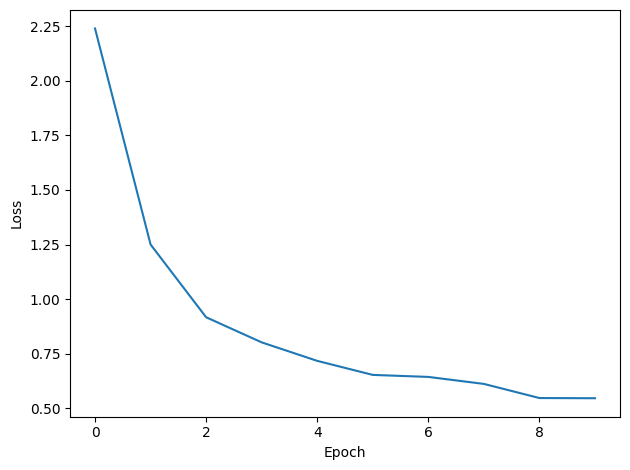

In [ ]:
# TRAINING

# Training parameters
nb_epochs = 10 # is quick, it won't have converged.
# Note: An epoch is one complete pass through the entire training dataset.
# During an epoch, the neural network processes every example in the dataset once.
# Completing an epoch means that every data point has been used for calculating the loss and updating the model parameters.
# Multiple epochs are usually required for the network to converge to an optimal set of parameters.
lr = 0.01 # learning rate

# Generate the training data
ipds, spikes, _ = random_ipd_input_signal(num_samples) # num_samples = batch_size * num_training

# Initialise a weight matrices
W1, W2 = init_weight_matrices()

# Optimiser and loss function
optimizer = torch.optim.Adam([W1, W2], lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
for e in range(nb_epochs):
    local_loss = []
    for spike_batch, ipd_batch in data_generator(discretise(ipds), spikes):
        # Run network
        output = snn(spike_batch, W1, W2)

        # Compute cross entropy loss
        m = torch.sum(output, 1)*0.01  # Agregation fuction: Sum across time dimension. Note: We want loss for epoch 1 to be about -np.log(1/num_classes), multiply m by a constant to get this
        loss = loss_fn(log_softmax_fn(m), ipd_batch)
        local_loss.append(loss.item())

        # The softmax function transforms the output of a neural network's final layer into a probability
        # distribution over multiple classes in such a way that increasing the score of one class
        # decreases the probabilities of the other classes. It does this by exponentiating each logit
        # and then normalizing these values so that they sum to 1. This is important because it ensures that
        # the predicted values for each class sum up to 1.0. This probability distribution allows us to
        # interpret the network's output as the likelihood of each class being the correct class.
        # Training Objective: The training process aims to increase the probability of the correct class.
          # As the model updates its weights to increase the probability (and hence the log probability) of the
          # correct class, the softmax function inherently decreases the probabilities of the other classes due
          # to the normalization step.
          # Using it with the negative log likelihood loss encourages the model to increase the log probability
          # of the correct class.
        # Interpretability: The softmax function's output can be interpreted as class probabilities, which is
          # valuable not only for making predictions but also for understanding the model's confidence in those
          # predictions. This can be useful for post-processing or decision-making based on the network's output
          # probabilities.

        # Update gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()


Chance accuracy level: 8.3%
Train classifier accuracy: 81.9%
Train absolute error: 4.8 deg 

Test classifier accuracy: 59.8%
Test absolute error: 7.3 deg 



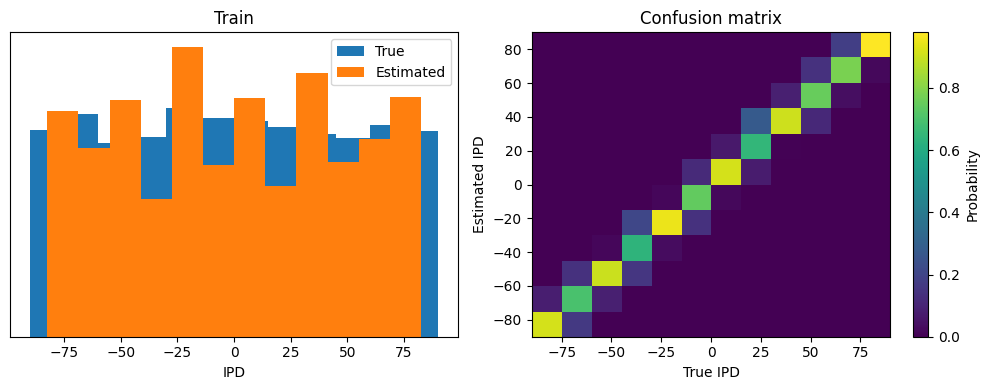

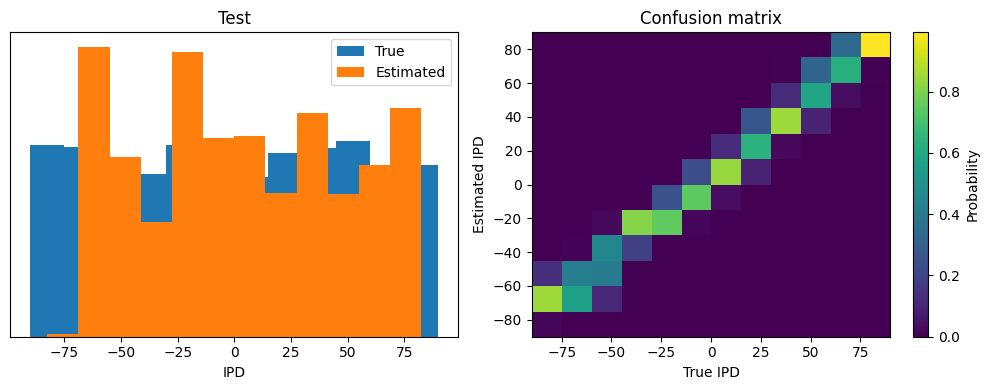

In [ ]:
# ANALYSIS

print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
run_func = lambda x: snn(x, W1, W2)
results_Train = analyse(ipds, spikes, 'Train', run=run_func, plot_analysis=1)
ipds_test, spikes_test, _ = random_ipd_input_signal(batch_size*n_testing_batches)
results_Train = analyse(ipds_test, spikes_test, 'Test', run=run_func, plot_analysis=1)

## Project
Change systematically some of the parameters and record the performance. You can do this for example by running the following code in a loop:

#### Example project: Envelope power


This code performs an analysis of the performance of a spiking neural network (SNN) classifier across a range of envelope power values.

Please note that the current code only plots the result of a single training session.


##### Suggestion for improvement:
  
* Run the example code from the EnvelopePower project multiple times.

* You will notice that the results vary significantly between consecutive training sessions.

* To draw robust conclusions, calculate the average across all training sessions.

* Then, plot a graph with the average and the corresponding standard deviation.

* Apply this same approach to your other projects to obtain reliable results.

Processing Envelope Powers:   0%|          | 0/11 [00:00<?, ?it/s]

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.89531
Epoch 2: loss=2.56350
Epoch 3: loss=2.55688
Epoch 4: loss=2.54151
Epoch 5: loss=2.55867
Epoch 6: loss=2.56998
Epoch 7: loss=2.57487
Epoch 8: loss=2.54971
Epoch 9: loss=2.57314
Epoch 10: loss=2.55917
Chance accuracy level: 8.3%
Train classifier accuracy: 8.5%
Train absolute error: 81.6 deg 



Processing Envelope Powers:   9%|▉         | 1/11 [01:35<15:53, 95.36s/it]

Test classifier accuracy: 9.0%
Test absolute error: 81.9 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.33419
Epoch 2: loss=1.65441
Epoch 3: loss=1.36353
Epoch 4: loss=1.17711
Epoch 5: loss=1.04945
Epoch 6: loss=0.96698
Epoch 7: loss=0.88339
Epoch 8: loss=0.84959
Epoch 9: loss=0.79340
Epoch 10: loss=0.76301
Chance accuracy level: 8.3%
Train classifier accuracy: 75.3%
Train absolute error: 5.4 deg 



Processing Envelope Powers:  18%|█▊        | 2/11 [03:17<14:51, 99.10s/it]

Test classifier accuracy: 37.7%
Test absolute error: 18.0 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.07705
Epoch 2: loss=1.19594
Epoch 3: loss=0.90318
Epoch 4: loss=0.77414
Epoch 5: loss=0.68335
Epoch 6: loss=0.62182
Epoch 7: loss=0.56845
Epoch 8: loss=0.53625
Epoch 9: loss=0.50982
Epoch 10: loss=0.47362
Chance accuracy level: 8.3%
Train classifier accuracy: 82.3%
Train absolute error: 4.8 deg 



Processing Envelope Powers:  27%|██▋       | 3/11 [04:54<13:07, 98.40s/it]

Test classifier accuracy: 73.1%
Test absolute error: 5.5 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.25014
Epoch 2: loss=1.42326
Epoch 3: loss=1.06085
Epoch 4: loss=0.84206
Epoch 5: loss=0.76002
Epoch 6: loss=0.69099
Epoch 7: loss=0.63662
Epoch 8: loss=0.59027
Epoch 9: loss=0.54963
Epoch 10: loss=0.51739
Chance accuracy level: 8.3%
Train classifier accuracy: 85.9%
Train absolute error: 4.3 deg 



Processing Envelope Powers:  36%|███▋      | 4/11 [06:51<12:20, 105.83s/it]

Test classifier accuracy: 72.0%
Test absolute error: 5.5 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.39491
Epoch 2: loss=1.73719
Epoch 3: loss=1.19429
Epoch 4: loss=0.94996
Epoch 5: loss=0.81627
Epoch 6: loss=0.71599
Epoch 7: loss=0.67003
Epoch 8: loss=0.61524
Epoch 9: loss=0.58288
Epoch 10: loss=0.54043
Chance accuracy level: 8.3%
Train classifier accuracy: 82.2%
Train absolute error: 4.7 deg 



Processing Envelope Powers:  45%|████▌     | 5/11 [08:44<10:50, 108.43s/it]

Test classifier accuracy: 42.1%
Test absolute error: 10.0 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=1.82377
Epoch 2: loss=1.07421
Epoch 3: loss=0.83659
Epoch 4: loss=0.70984
Epoch 5: loss=0.60545
Epoch 6: loss=0.59717
Epoch 7: loss=0.50561
Epoch 8: loss=0.49164
Epoch 9: loss=0.43368
Epoch 10: loss=0.42457
Chance accuracy level: 8.3%
Train classifier accuracy: 82.3%
Train absolute error: 4.9 deg 



Processing Envelope Powers:  55%|█████▍    | 6/11 [10:29<08:56, 107.28s/it]

Test classifier accuracy: 66.3%
Test absolute error: 6.4 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=1.80832
Epoch 2: loss=1.06946
Epoch 3: loss=0.85821
Epoch 4: loss=0.75574
Epoch 5: loss=0.65996
Epoch 6: loss=0.60306
Epoch 7: loss=0.55271
Epoch 8: loss=0.55661
Epoch 9: loss=0.50147
Epoch 10: loss=0.46506
Chance accuracy level: 8.3%
Train classifier accuracy: 84.3%
Train absolute error: 4.6 deg 



Processing Envelope Powers:  64%|██████▎   | 7/11 [12:03<06:50, 102.69s/it]

Test classifier accuracy: 59.3%
Test absolute error: 10.1 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=1.58658
Epoch 2: loss=0.82139
Epoch 3: loss=0.62033
Epoch 4: loss=0.52556
Epoch 5: loss=0.45369
Epoch 6: loss=0.39074
Epoch 7: loss=0.35321
Epoch 8: loss=0.31767
Epoch 9: loss=0.31205
Epoch 10: loss=0.28176
Chance accuracy level: 8.3%
Train classifier accuracy: 92.2%
Train absolute error: 4.0 deg 



Processing Envelope Powers:  73%|███████▎  | 8/11 [13:29<04:52, 97.35s/it] 

Test classifier accuracy: 65.3%
Test absolute error: 8.2 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=1.52652
Epoch 2: loss=0.84618
Epoch 3: loss=0.62511
Epoch 4: loss=0.50149
Epoch 5: loss=0.44108
Epoch 6: loss=0.39021
Epoch 7: loss=0.35989
Epoch 8: loss=0.33581
Epoch 9: loss=0.29677
Epoch 10: loss=0.26981
Chance accuracy level: 8.3%
Train classifier accuracy: 92.3%
Train absolute error: 4.1 deg 



Processing Envelope Powers:  82%|████████▏ | 9/11 [14:56<03:08, 94.10s/it]

Test classifier accuracy: 42.0%
Test absolute error: 18.3 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=1.63794
Epoch 2: loss=0.84684
Epoch 3: loss=0.61129
Epoch 4: loss=0.48286
Epoch 5: loss=0.42421
Epoch 6: loss=0.37670
Epoch 7: loss=0.34275
Epoch 8: loss=0.32541
Epoch 9: loss=0.31193
Epoch 10: loss=0.27732
Chance accuracy level: 8.3%
Train classifier accuracy: 92.3%
Train absolute error: 4.0 deg 



Processing Envelope Powers:  91%|█████████ | 10/11 [16:23<01:32, 92.13s/it]

Test classifier accuracy: 84.4%
Test absolute error: 4.4 deg 

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=1.57687
Epoch 2: loss=0.91794
Epoch 3: loss=0.69698
Epoch 4: loss=0.57263
Epoch 5: loss=0.50361
Epoch 6: loss=0.44204
Epoch 7: loss=0.40247
Epoch 8: loss=0.37110
Epoch 9: loss=0.35624
Epoch 10: loss=0.32473
Chance accuracy level: 8.3%
Train classifier accuracy: 90.1%
Train absolute error: 4.3 deg 



Processing Envelope Powers: 100%|██████████| 11/11 [17:49<00:00, 97.25s/it]

Test classifier accuracy: 80.9%
Test absolute error: 5.4 deg 



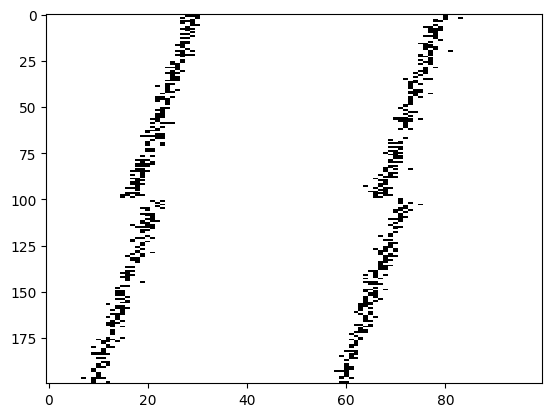

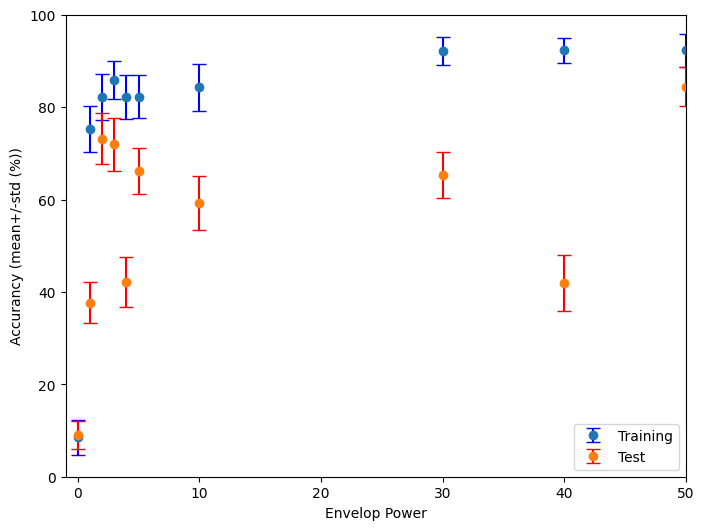

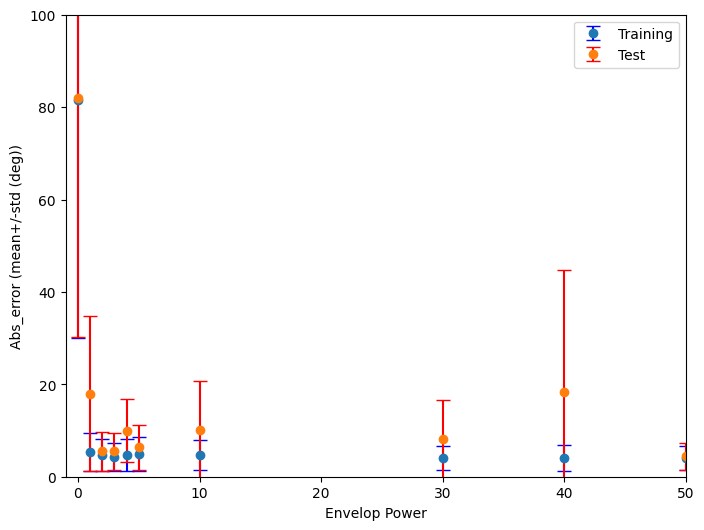

In [ ]:
from tqdm import tqdm # Import the tqdm library for displaying a progress bar

# Set training parameters
nb_epochs = 10  # Number of epochs (quick training for demonstration)
lr = 0.01       # Learning rate

# Flag for whether to plot analysis results
plot_analysis = 0

# Define a range of envelope powers to test
Envelop_powers = [0, 1, 2, 3, 4, 5, 10, 30, 40, 50, 100]

# Initialize lists to store results for training and testing accuracy and absolute error.
# Mean and std are calulated over the different batches
Train_accuracy_mean = []   # Mean training accuracy
Train_accuracy_std = []    # Standard deviation of training accuracy
Train_abs_error_mean = []  # Mean training absolute error
Train_abs_error_std = []   # Standard deviation of training absolute error

Test_accuracy_mean = []    # Mean testing accuracy
Test_accuracy_std = []     # Standard deviation of testing accuracy
Test_abs_error_mean = []   # Mean testing absolute error
Test_abs_error_std = []    # Standard deviation of testing absolute error

results_Train = []  # Stores results from training data
results_Test = []   # Stores results from test data

# Loop through each envelope power, showing progress with tqdm
for i, envelope_power in enumerate(tqdm(Envelop_powers, desc="Processing Envelope Powers")):

    # Generate training data: interaural phase differences (IPDs) and spike data
    ipds, spikes, _ = random_ipd_input_signal(num_samples)
    plt.imshow(spikes[0, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)

    # Initialize weight matrices for the neural network classifier
    W1, W2 = init_weight_matrices()

    # Define the optimizer and loss functions
    optimizer = torch.optim.Adam([W1, W2], lr=lr)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    # Print the expected initial loss
    print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

    loss_hist = []  # Track loss over epochs
    for e in range(nb_epochs):  # Loop through each epoch
        local_loss = []  # Track batch losses for the current epoch
        for spike_batch, ipd_batch in data_generator(discretise(ipds), spikes):  # Generate data batches
            # Run the classifier on the batch
            output = snn(spike_batch, W1, W2)

            # Compute cross-entropy loss
            m = torch.sum(output, 1) * 0.01  # Aggregate output over the time dimension
            loss = loss_fn(log_softmax_fn(m), ipd_batch)
            local_loss.append(loss.item())

            # Update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Append the mean loss for the epoch
        loss_hist.append(np.mean(local_loss))
        print("Epoch %i: loss=%.5f" % (e + 1, np.mean(local_loss)))

    # Optionally plot the loss curve over epochs
    if plot_analysis:
      # Plot the loss function over time
      plt.plot(loss_hist)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.tight_layout()


    # Analyse training data
    print(f"Chance accuracy level: {100*1/num_classes:.1f}%")

    run_func = lambda x: snn(x, W1, W2) # Define the classifier function
    results_Train = analyse(ipds, spikes, 'Train', run=run_func, plot_analysis=0)

    # Generate and analyse test data
    ipds_test, spikes_test, _ = random_ipd_input_signal(batch_size*n_testing_batches)
    results_Test = analyse(ipds_test, spikes_test, 'Test', run=run_func, plot_analysis=0)

    # Append training results
    Train_accuracy_mean.append(results_Train[0])
    Train_accuracy_std.append(results_Train[1])
    Train_abs_error_mean.append(results_Train[2])
    Train_abs_error_std.append(results_Train[3])

    # Append testing results
    Test_accuracy_mean.append(results_Test[0])
    Test_accuracy_std.append(results_Test[1])
    Test_abs_error_mean.append(results_Test[2])
    Test_abs_error_std.append(results_Test[3])

# Plot training and testing accuracy with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(Envelop_powers,Train_accuracy_mean, yerr=Train_accuracy_std, label='Training',fmt='o', ecolor='blue', capsize=5)
plt.errorbar(Envelop_powers,Test_accuracy_mean, yerr=Test_accuracy_std, label='Test', fmt='o', ecolor='red', capsize=5)
plt.ylim([0,100])
plt.xlim([-1,50])
plt.xlabel('Envelop Power')
plt.ylabel('Accurancy (mean+/-std (%))')
plt.legend()

# Plot training and testing absolute error with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(Envelop_powers,Train_abs_error_mean, yerr=Train_abs_error_std, label='Training',fmt='o', ecolor='blue', capsize=5)
plt.errorbar(Envelop_powers,Test_abs_error_mean, yerr=Test_abs_error_std, label='Test', fmt='o', ecolor='red', capsize=5)
plt.ylim([0,100])
plt.xlim([-1,50])
plt.xlabel('Envelop Power')
plt.ylabel('Abs_error (mean+/-std (deg))')
plt.legend()

In [ ]:
plt.savefig("Proj_EnvelopePower.png")  # Save the plot as a PNG file

!cp Proj_EnvelopePower.png "/content/drive/My Drive/Mini-Project_ColabNotebooks/SBCP_2024/Results_Figures"

!ls "/content/drive/My Drive/Mini-Project_ColabNotebooks/SBCP_2024/Results_Figures"


example_plot.png  Proj_EnvelopePower.png


<Figure size 640x480 with 0 Axes>